<h1 style="text-align: center;">Implementation of LSTM for Sentiment Classification on IMDB Movie Reviews</h1>
<h3>Author: Johan Winarwan Nawawi | 3322600023 | 3 STr SDT A</h3>

# 1. Conduct an experiment for LSTM

## Import Library

In [1]:
import re
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings('ignore')

## Download Requirement File

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JOHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JOHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Read Dataset IMDB

In [3]:
df = pd.read_csv('Data/IMDB/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Encoding Label

In [4]:
df.sentiment = [1 if s == 'positive' else 0 for s in df.sentiment]
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Data Preprocessing

In [5]:
idx = random.randint(0, len(df)-1)
before_process = df.iloc[idx][0]

def process(x):
  x = re.sub('[,\.!?:()"]', '', x)
  x = re.sub('<.*?>', ' ', x)
  x = re.sub('http\S+', ' ', x)
  x = re.sub('[^a-zA-Z0-9]', ' ', x)
  x = re.sub('\s+', ' ', x)
  return x.lower().strip()

df['review'] = df['review'].apply(lambda x: process(x))
after_process = df.iloc[idx][0]
after_process

'crackerjack is another classic aussie film as so many australian films like the castle the dish and sunday too far away it goes somewhere that hasn t been widely explored in film before this time it is the game of lawn bowls and bowling clubs crackerjack is a much slower paced sports movie than many you will find such as remember the titans or million dollar babybut the characters involved are athletes in their own right this movie is a show case of a large area of australian culture and features a sport that is popular and on the rise of popularity in australia mick molloy presents a classic unforgettable character it really is a must see'

## Remove Stopword

In [6]:
sw_set = set(nltk.corpus.stopwords.words('english'))

def sw_remove(x):
  words = nltk.tokenize.word_tokenize(x)
  filtered_list = [word for word in words if word not in sw_set]
  return ' '.join(filtered_list)

df['review'] = df['review'].apply(lambda x: sw_remove(x))
after_removal = sw_remove(after_process)
after_removal

'crackerjack another classic aussie film many australian films like castle dish sunday far away goes somewhere widely explored film time game lawn bowls bowling clubs crackerjack much slower paced sports movie many find remember titans million dollar babybut characters involved athletes right movie show case large area australian culture features sport popular rise popularity australia mick molloy presents classic unforgettable character really must see'

### Proprocessing Result

In [7]:
print('\033[1m' + 'Review #%d before preprocessing:' % idx + '\033[0m' + '\n', before_process, '\n')

print('\033[1m' + 'Review #%d after preprocessing:' % idx + '\033[0m' + '\n', after_process, '\n')

print('\033[1m' + 'Review #%d after preprocessing and stopwords removal:' % idx + '\033[0m' + '\n', after_removal)

Review #2604 before preprocessing:
 Crackerjack is another classic Aussie film. As so many Australian films like The Castle, The Dish and Sunday Too Far Away, it goes somewhere that hasn't been widely explored in film before, this time it is the game of Lawn Bowls and bowling clubs. Crackerjack is a much slower paced sports movie than many you will find such as Remember the Titans or Million Dollar Babybut the characters involved are athletes in their own right. This movie is a show case of a large area of Australian culture and features a sport that is popular and on the rise of popularity in Australia. Mick Molloy presents a classic, unforgettable character. It really is a must see. 

Review #2604 after preprocessing:
 crackerjack is another classic aussie film as so many australian films like the castle the dish and sunday too far away it goes somewhere that hasn t been widely explored in film before this time it is the game of lawn bowls and bowling clubs crackerjack is a much slow

## Splitting Data

In [8]:
train_rev, test_rev, train_sent, test_sent = train_test_split(df['review'], df['sentiment'],
                                                              test_size=0.1, random_state=42)

## File Tokenizer

In [9]:
dict_size = 35000
tokenizer = Tokenizer(num_words=dict_size)
tokenizer.fit_on_texts(df['review'])

## Fit Tokenizer to Data Split

In [10]:
train_rev_tokens = tokenizer.texts_to_sequences(train_rev)
test_rev_tokens = tokenizer.texts_to_sequences(test_rev)
seq_lengths = np.array([len(sequence) for sequence in train_rev_tokens])

## Store Upper Bound Sequence

In [11]:
upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
percentage = stats.percentileofscore(seq_lengths, upper_bound)

## Resize Length Sequence

In [12]:
train_rev_pad = pad_sequences(train_rev_tokens, maxlen=upper_bound)
test_rev_pad = pad_sequences(test_rev_tokens, maxlen=upper_bound)

## LSTM Model

In [13]:
output_dim = 14
units_lstm = 16
r = 0.8

model = Sequential()
model.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model.add(LSTM(units_lstm))
model.add(Dropout(r))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Compile Model

In [14]:
model.compile(loss= 'binary_crossentropy', optimizer= 'adam',  metrics=['accuracy'])

## Model Fit

In [15]:
validation_split = 0.1
batch_size = 384
epochs = 10

fitted = model.fit(train_rev_pad, train_sent, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.5720 - loss: 0.6777 - val_accuracy: 0.8044 - val_loss: 0.4905
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8419 - loss: 0.4244 - val_accuracy: 0.8929 - val_loss: 0.2790
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9157 - loss: 0.2714 - val_accuracy: 0.8918 - val_loss: 0.2650
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.9364 - loss: 0.2091 - val_accuracy: 0.8938 - val_loss: 0.2771
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.9512 - loss: 0.1684 - val_accuracy: 0.8924 - val_loss: 0.2977
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.9608 - loss: 0.1433 - val_accuracy: 0.8880 - val_loss: 0.3212
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.9662 - loss: 0.1234 - val_accuracy: 0.8856 - val_loss: 0.3653
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9723 - loss: 0.1054 - val_acc

## Ploting

Text(0, 0.5, 'Loss')

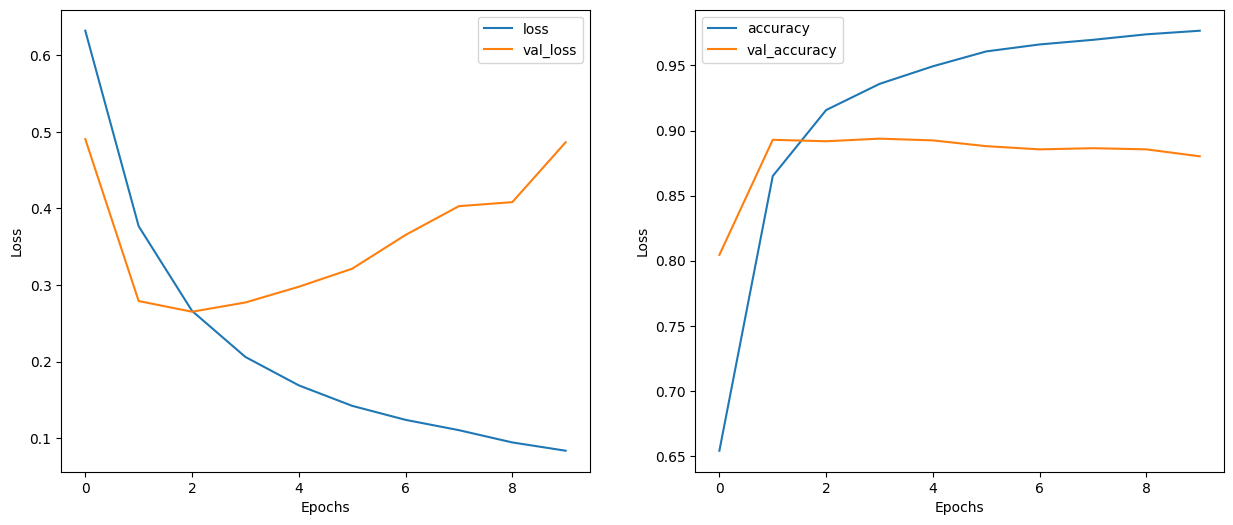

In [16]:
hist_df=pd.DataFrame(fitted.history)

fig, axes = plt.subplots(1,2 , figsize = (15,6))

#Loss
ax = axes[0]
hist_df.plot(y = ['loss','val_loss'], ax = ax)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

#ACC
ax1 = axes[1]
hist_df.plot(y = ['accuracy', 'val_accuracy'], ax = ax1)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

## Evaluate Model

In [17]:
result= model.evaluate(test_rev_pad, test_sent)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8834 - loss: 0.4656


## Confusion Matrix

In [18]:
predictions = np.round(model.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_sent, predictions)
print(cf_matrix)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[[2185  296]
 [ 303 2216]]


## Confusion Matrix Plotting

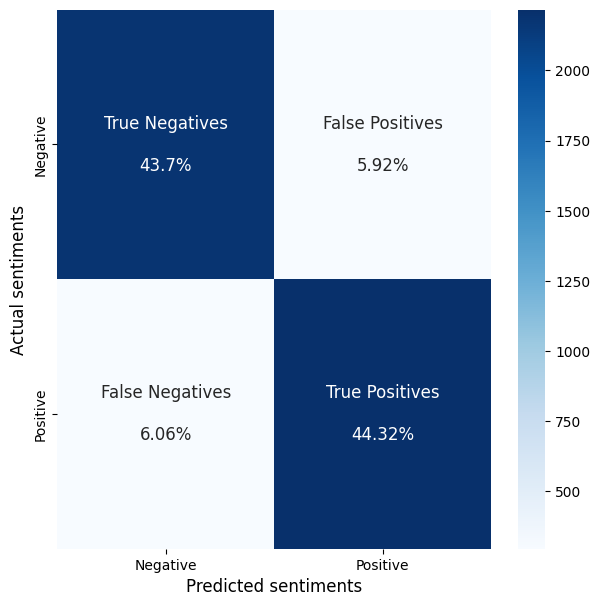

In [19]:
legends = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
percentages = [round(100*num, 2) for num in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n\n{v2}%' for v1, v2 in zip(legends, percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (7, 7))

cm = sns.heatmap(cf_matrix, annot=labels, fmt='s', cmap=plt.cm.Blues, annot_kws={'fontsize': 'large'})
cm.set_xlabel('Predicted sentiments', size='large')
cm.set_ylabel('Actual sentiments', size='large')
cm.xaxis.set_ticklabels(['Negative', 'Positive'])
cm.yaxis.set_ticklabels(['Negative', 'Positive'])

plt.show()

## Classification Report - Test Sentiment

In [20]:
print(classification_report(test_sent, predictions))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2481
           1       0.88      0.88      0.88      2519

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



# 2. Make parameter adjustments to avoid underfitting/overfitting

## LSTM Model with Adjusted Parameters - Model 1

In [21]:
output_dim = 14
units_lstm = 16
r = 0.3 # adjust dropout rate

model1 = Sequential()
model1.add(Embedding(input_dim=dict_size, output_dim= output_dim, input_length= upper_bound))
model1.add(LSTM(units_lstm))
model1.add(Dropout(r))
model1.add(Dense(1, activation='sigmoid'))
model1.build(input_shape=(None, upper_bound))
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 291, 14)        │       490,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 492,001 (1.88 MB)

 Trainable params: 492,001 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

## Compile Model 1

In [22]:
# compile model1
model1.compile(loss= 'binary_crossentropy', optimizer= 'adamax',  metrics=['accuracy']) # using optimizer 'adamax'

# Model fit
validation_split = 0.1
batch_size = 400 # adjusting batch size
epochs = 20 # increase the number of epochs

# set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

fitted1 = model1.fit(train_rev_pad, train_sent, validation_split=validation_split,
                    batch_size=batch_size, epochs=epochs, shuffle=True, callbacks=[early_stopping])

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.5632 - loss: 0.6916 - val_accuracy: 0.7518 - val_loss: 0.6698
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.7222 - loss: 0.6234 - val_accuracy: 0.8156 - val_loss: 0.4718
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8581 - loss: 0.4425 - val_accuracy: 0.8733 - val_loss: 0.3874
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8874 - loss: 0.3564 - val_accuracy: 0.8813 - val_loss: 0.3353
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9060 - loss: 0.2988 - val_accuracy: 0.8876 - val_loss: 0.3092
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9155 - loss: 0.2675 - val_accuracy: 0.8940 - val_loss: 0.2892
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9227 - loss: 0.2421 - val_accuracy: 0.8962 - val_loss: 0.2749
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9326 - loss: 0.2198 - val_acc

## Evaluation Model 1

In [23]:
result= model1.evaluate(test_rev_pad, test_sent)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8989 - loss: 0.2540


## Plot Train and Validation - Loss and Accuracy

Text(0, 0.5, 'Loss')

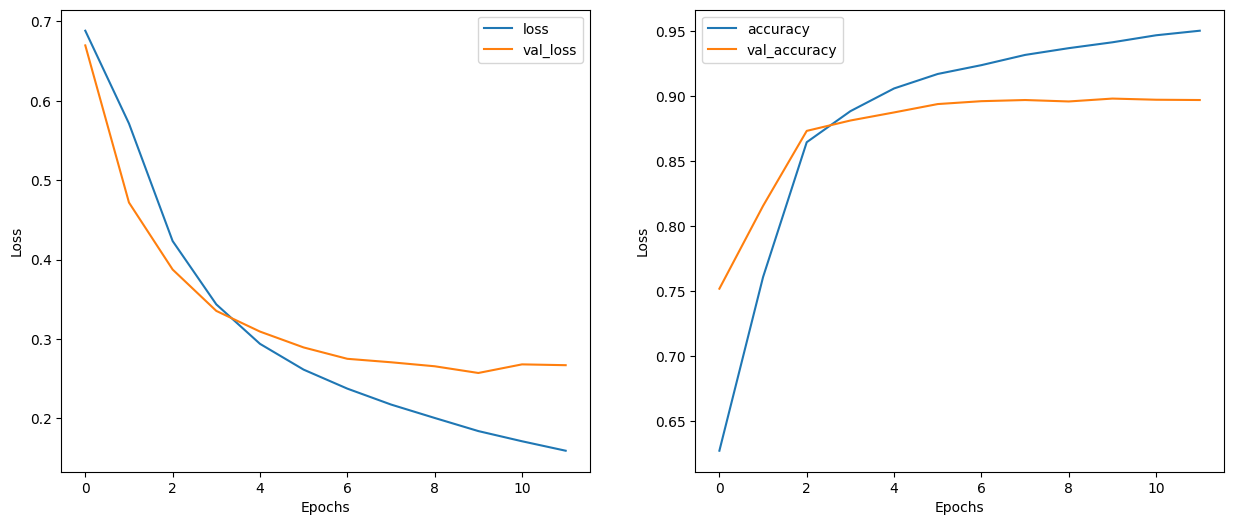

In [24]:
# Plot loss

hist_df=pd.DataFrame(fitted1.history)

fig, axes = plt.subplots(1,2 , figsize = (15,6))

#Loss
ax = axes[0]
hist_df.plot(y = ['loss','val_loss'], ax = ax)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

#ACC
ax1 = axes[1]
hist_df.plot(y = ['accuracy', 'val_accuracy'], ax = ax1)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

## Confusion Matrix

In [25]:
predictions1 = np.round(model1.predict(test_rev_pad))
cf_matrix1 = confusion_matrix(test_sent, predictions1)
print(cf_matrix1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[[2206  275]
 [ 223 2296]]


## Confusion Matrix Plotting

[[2206  275]
 [ 223 2296]] 



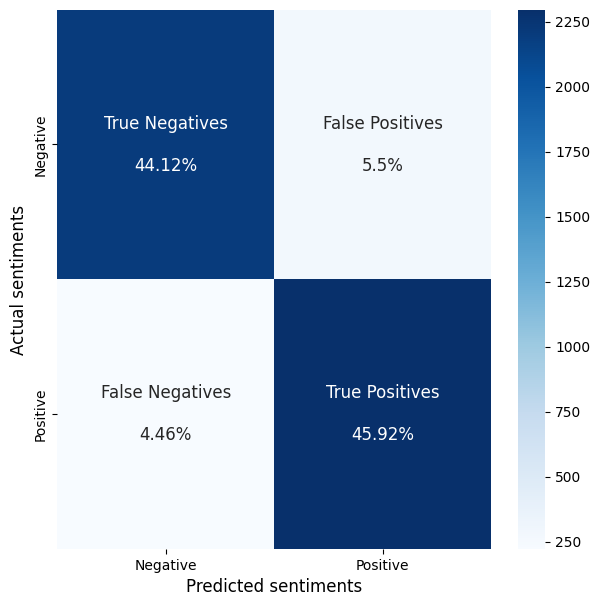

In [26]:
# cosfusion Matrix
cf_matrix1 = confusion_matrix(test_sent, predictions1)
print(cf_matrix1, '\n')

# confusion Matrix Plotting
legends = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
percentages = [round(100*num, 2) for num in cf_matrix1.flatten()/np.sum(cf_matrix1)]

labels = [f'{v1}\n\n{v2}%' for v1, v2 in zip(legends, percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (7, 7))

cm = sns.heatmap(cf_matrix1, annot=labels, fmt='s', cmap=plt.cm.Blues, annot_kws={'fontsize': 'large'})
cm.set_xlabel('Predicted sentiments', size='large')
cm.set_ylabel('Actual sentiments', size='large')
cm.xaxis.set_ticklabels(['Negative', 'Positive'])
cm.yaxis.set_ticklabels(['Negative', 'Positive'])

plt.show()

## Classification Report - Test Sentiment Model 1

In [27]:
# classification report
print(classification_report(test_sent, predictions1))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2481
           1       0.89      0.91      0.90      2519

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



# 3. Find parameters with the best evaluation metrics

## Model Summary

In [28]:
# Built-in model from the module
print(" Built-in model from the module ".center(60, "="))
model.summary()

# For model1
print(" Model 1 Summary ".center(60, "="))
model1.summary()


============== Built-in model from the module ==============


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 291, 14)        │       490,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,476,005 (5.63 MB)

 Trainable params: 492,001 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 984,004 (3.75 MB)

===================== Model 1 Summary ======================


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 291, 14)        │       490,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,476,005 (5.63 MB)

 Trainable params: 492,001 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 984,004 (3.75 MB)

## Model Evaluate - Model and Model 1

In [29]:
data = {
    "Model": ["Model1", "Built-in Model from the Module"],
    "Evaluation Result": [
        model1.evaluate(test_rev_pad, test_sent),
        model.evaluate(test_rev_pad, test_sent)
    ]
}

evaluation_df = pd.DataFrame(data)
evaluation_df


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8989 - loss: 0.2540
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8834 - loss: 0.4656


,Model,Evaluation Result
0,Model1,"[0.25699496269226074, 0.9003999829292297]"
1,Built-in Model from the Module,"[0.4751432538032532, 0.8802000284194946]"


## Plot Accuracy and Loss Model

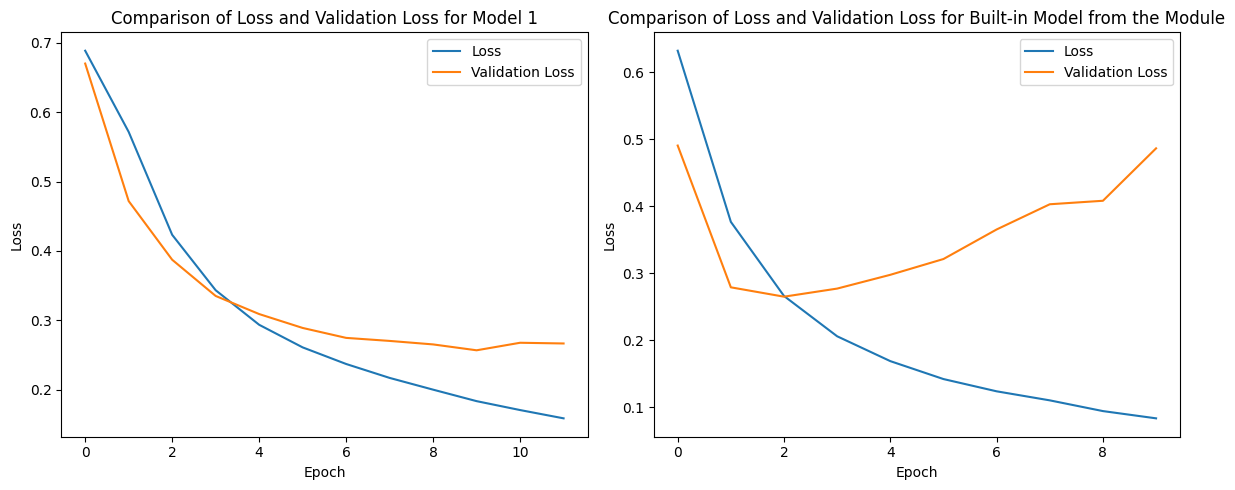

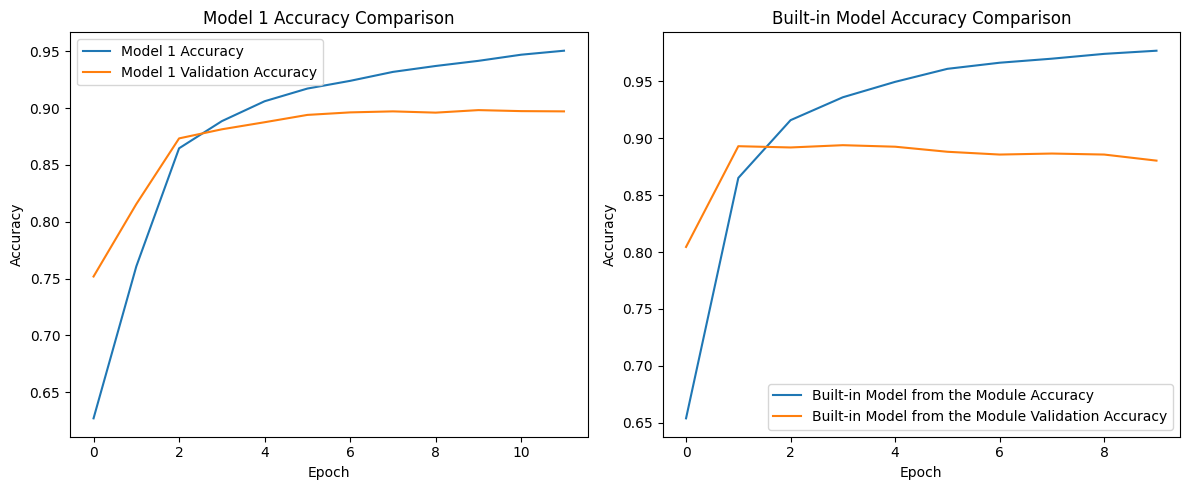

In [30]:
# plot for model 1
hist1_df = pd.DataFrame(fitted1.history)

# plot loss and validation loss for model 1
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist1_df['loss'], label='Loss')
plt.plot(hist1_df['val_loss'], label='Validation Loss')
plt.title('Comparison of Loss and Validation Loss for Model 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot for built-in model from the module
hist2_df = pd.DataFrame(fitted.history)

# plot loss and validation loss for built-in model from the module
plt.subplot(1, 2, 2)
plt.plot(hist2_df['loss'], label='Loss')
plt.plot(hist2_df['val_loss'], label='Validation Loss')
plt.title('Comparison of Loss and Validation Loss for Built-in Model from the Module')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# combined plot for accuracy and validation accuracy
plt.figure(figsize=(12, 5))

# Create subplots for accuracy
plt.subplot(1, 2, 1)
plt.plot(hist1_df['accuracy'], label='Model 1 Accuracy')
plt.plot(hist1_df['val_accuracy'], label='Model 1 Validation Accuracy')
plt.title('Model 1 Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist2_df['accuracy'], label='Built-in Model from the Module Accuracy')
plt.plot(hist2_df['val_accuracy'], label='Built-in Model from the Module Validation Accuracy')
plt.title('Built-in Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# 4. Conduct an experiment using RNN and compare it with the results of LSTM

### LSTM Model

In [31]:
# general parameters
output_dim = 14
units_lstm = 16
units_rnn = 16
dropout_rate = 0.3
validation_split = 0.1
batch_size = 400
epochs = 20

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# 1. lstm model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
lstm_model.add(LSTM(units_lstm))
lstm_model.add(Dropout(dropout_rate))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.build(input_shape=(None, upper_bound))
lstm_model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

# train lstm model
fitted_lstm = lstm_model.fit(train_rev_pad, train_sent, validation_split=validation_split,
                            batch_size=batch_size, epochs=epochs, shuffle=True, callbacks=[early_stopping])

# evaluate lstm model
result_lstm = lstm_model.evaluate(test_rev_pad, test_sent)

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.5471 - loss: 0.6912 - val_accuracy: 0.6084 - val_loss: 0.6489
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.7807 - loss: 0.5853 - val_accuracy: 0.8440 - val_loss: 0.4939
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.8538 - loss: 0.4727 - val_accuracy: 0.8578 - val_loss: 0.4540
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.8769 - loss: 0.4138 - val_accuracy: 0.8618 - val_loss: 0.4023
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.8876 - loss: 0.3643 - val_accuracy: 0.8631 - val_loss: 0.3780
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.8969 - loss: 0.3354 - val_accuracy: 0.8767 - val_loss: 0.3628
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9095 - loss: 0.3072 - val_accuracy: 0.8802 - val_loss: 0.3447
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.9167 - loss: 0.2818 - val_acc

### RNN Model

In [32]:
# 2. model rnn
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
rnn_model.add(SimpleRNN(units_rnn))
rnn_model.add(Dropout(dropout_rate))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.build(input_shape=(None, upper_bound))
rnn_model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

# train rnn model
fitted_rnn = rnn_model.fit(train_rev_pad, train_sent, validation_split=validation_split,
                        batch_size=batch_size, epochs=epochs, shuffle=True, callbacks=[early_stopping])

# evaluate rnn model
result_rnn = rnn_model.evaluate(test_rev_pad, test_sent)


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5075 - loss: 0.6982 - val_accuracy: 0.5176 - val_loss: 0.6916
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5524 - loss: 0.6853 - val_accuracy: 0.5604 - val_loss: 0.6835
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5246 - loss: 0.6918


## Compare Evaluate Model

In [33]:
# comparing the results of both models
results_df = pd.DataFrame({
    'model': ['lstm model', 'rnn model'],
    'accuracy': [result_lstm[1], result_rnn[1]],
    'loss': [result_lstm[0], result_rnn[0]]
})

# display the comparison results
results_df

,model,accuracy,loss
0,lstm model,0.8814,0.314524
1,rnn model,0.5244,0.691133


In [37]:
# classification report lstm
predictions_lstm = np.round(lstm_model.predict(test_rev_pad))
print(classification_report(test_sent, predictions_lstm))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2481
           1       0.87      0.91      0.88      2519

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [38]:
# classification report lstm
predictions_rnn = np.round(rnn_model.predict(test_rev_pad))
print(classification_report(test_sent, predictions_rnn))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      2481
           1       0.53      0.54      0.53      2519

    accuracy                           0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.52      0.52      0.52      5000



## Viz Compare Model

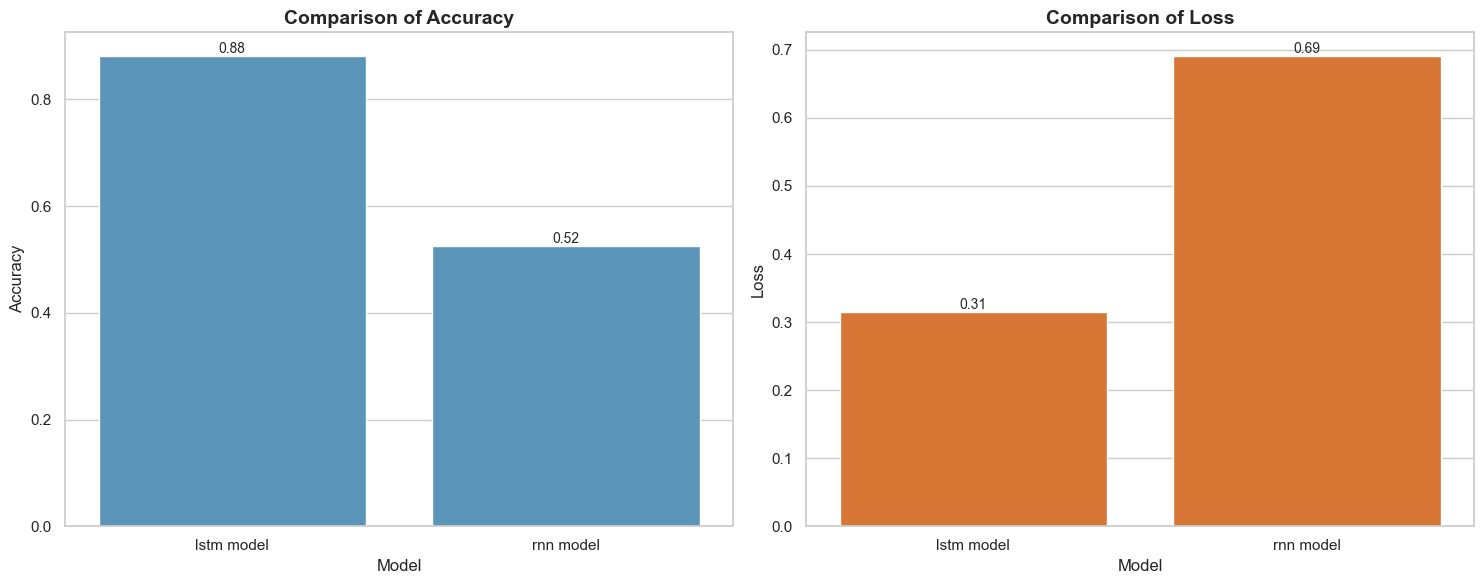

In [34]:
# set the style using seaborn with soft colors
sns.set(style="whitegrid")

# colors for the plots (soft blue and soft orange)
soft_blue = sns.color_palette("Blues", 4)[2]  # soft blue color
soft_orange = sns.color_palette("Oranges", 4)[2]  # soft orange color

# visualizing the comparison results between lstm and rnn
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# plot accuracy comparison
sns.barplot(x='model', y='accuracy', data=results_df, ax=axes[0], color=soft_blue)
axes[0].set_title('Comparison of Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.2f', fontsize=10)  # add value labels above bars

# plot loss comparison
sns.barplot(x='model', y='loss', data=results_df, ax=axes[1], color=soft_orange)
axes[1].set_title('Comparison of Loss', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f', fontsize=10)  # add value labels above bars

plt.tight_layout()
plt.show()

## Plot Loss and Accuracy per Epoch for LSTM

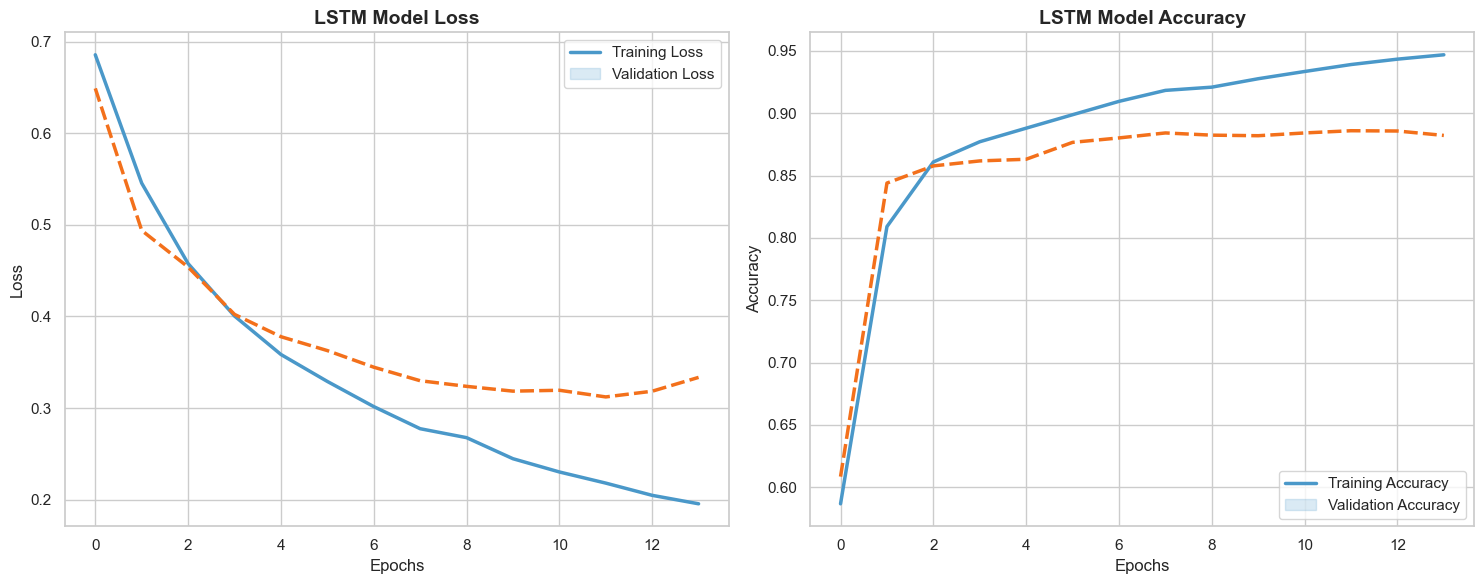

In [35]:
hist_lstm_df = pd.DataFrame(fitted_lstm.history)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# plot lstm loss
ax = axes[0]
sns.lineplot(data=hist_lstm_df[['loss', 'val_loss']], ax=ax, palette=[soft_blue, soft_orange], linewidth=2.5)
ax.set_title('LSTM Model Loss', fontsize=14, fontweight='bold')
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(['Training Loss', 'Validation Loss'], loc='upper right')
ax.grid(True)

# plot lstm accuracy
ax1 = axes[1]
sns.lineplot(data=hist_lstm_df[['accuracy', 'val_accuracy']], ax=ax1, palette=[soft_blue, soft_orange], linewidth=2.5)
ax1.set_title('LSTM Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
ax1.grid(True)

plt.tight_layout()
plt.show()

## Plot Loss and Accuracy per Epoch for RNN

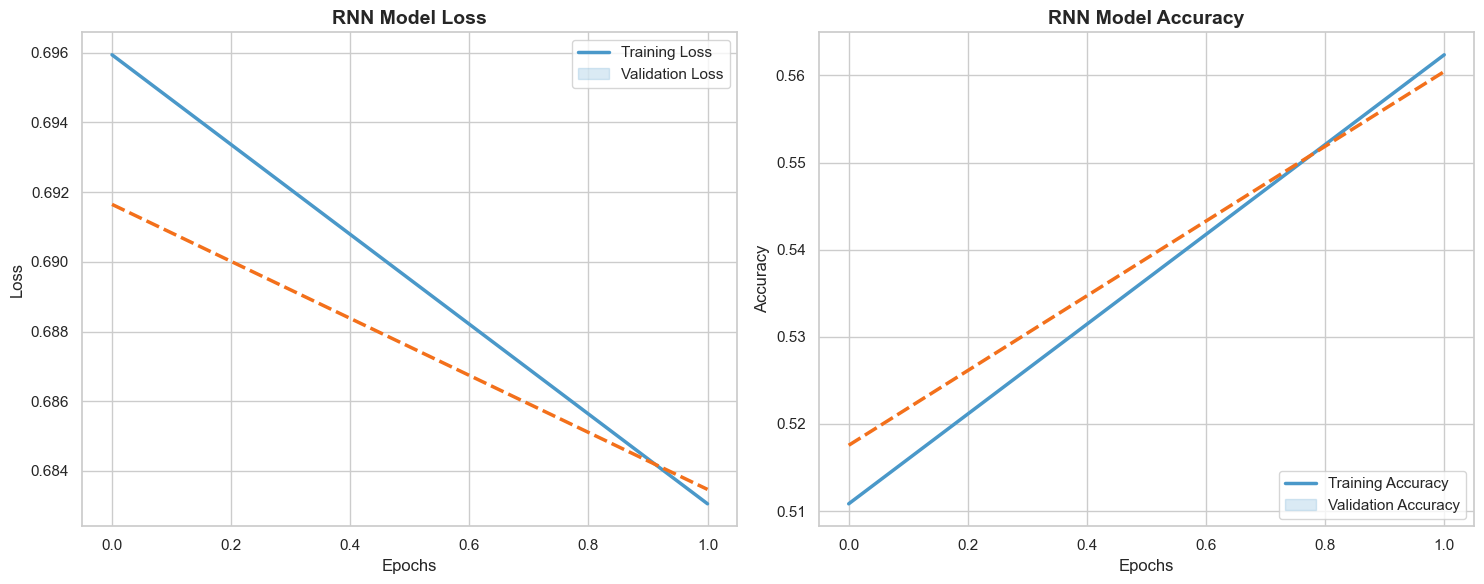

In [36]:
hist_rnn_df = pd.DataFrame(fitted_rnn.history)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# plot RNN loss
ax = axes[0]
sns.lineplot(data=hist_rnn_df[['loss', 'val_loss']], ax=ax, palette=[soft_blue, soft_orange], linewidth=2.5)
ax.set_title('RNN Model Loss', fontsize=14, fontweight='bold')
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(['Training Loss', 'Validation Loss'], loc='upper right')
ax.grid(True)

# plot RNN accuracy
ax1 = axes[1]
sns.lineplot(data=hist_rnn_df[['accuracy', 'val_accuracy']], ax=ax1, palette=[soft_blue, soft_orange], linewidth=2.5)
ax1.set_title('RNN Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
ax1.grid(True)

plt.tight_layout()
plt.show()